(props_doss)=

# Properties: Density of States (DOSS)

The {py:class}`~.aiida_crystal17.calculations.prop_doss.CryDossCalculation` can be used to run the `properties`
executable for DOSS calculations, from an existing `fort.9`.

:::{seealso}
{ref}`props_workflow` to run multiple properties calculations
(and optional initial SCF).
:::

In [2]:
!verdi plugin list aiida.calculations crystal17.doss

Inputs
           code:  required  Code                                    The Code to use for this job.
     parameters:  required  Dict                                    the input parameters to create the properties input file.
      wf_folder:  required  FolderData, RemoteData, SinglefileData  the folder containing the wavefunction fort.9 file
       metadata:  optional                                          
Outputs
  remote_folder:  required  RemoteData                              Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict                                    Summary Data extracted from the output file(s)
      retrieved:  required  FolderData                              Files that are retrieved by the daemon will be stored in this node. By defa ...
         arrays:  optional  ArrayData                               energies and DoS arrays
Exit codes
              1:  The process has failed with an unspecifie

In [2]:
from aiida import engine, load_profile, orm, plugins
from aiida.tools.visualization import Graph
from aiida_crystal17.common import recursive_round
from aiida_crystal17.tests.utils import (
    get_or_create_local_computer, get_or_create_code,
    get_default_metadata)
from aiida_crystal17.tests import open_resource_binary
import matplotlib.pyplot as plt
%matplotlib inline
profile = load_profile()
profile.name

'test_crystal17'

## Running a calculation

The {ref}`doss_input_schema` gives the allowed format of the input dictionary, for example:

In [16]:
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.doss', computer, 'mock_properties17')

builder = code.get_builder()
builder.metadata = get_default_metadata()
builder.parameters = orm.Dict(dict={
    "k_points": [18, 36],
    "npoints": 100,
    "band_minimum": -10,
    "band_maximum": 10,
    "band_units": "eV"
})
with open_resource_binary('doss', 'mgo_sto3g_scf', 'fort.9') as handle:
    builder.wf_folder = orm.SinglefileData(handle)

In [19]:
result, calcnode = engine.run_get_node(builder)

In [20]:
!verdi process show {calcnode.pk}

Property       Value
-------------  ------------------------------------
type           CalcJobNode
pk             884
uuid           ff55e9d9-9a03-4375-b5d9-2353794f1c92
label
description
ctime          2019-09-24 14:04:37.274585+00:00
mtime          2019-09-24 14:04:51.167679+00:00
process state  Finished
exit status    0
computer       [1] localhost

Inputs        PK  Type
----------  ----  --------------
code         881  Code
parameters   882  Dict
wf_folder    883  SinglefileData

Outputs          PK  Type
-------------  ----  ----------
arrays          888  ArrayData
remote_folder   885  RemoteData
results         887  Dict
retrieved       886  FolderData


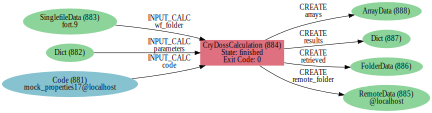

In [21]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode)
graph.add_incoming(calcnode, annotate_links="both")
graph.add_outgoing(calcnode, annotate_links="both")
graph.graphviz

## Analysing the outputs

The outputs are:

- **results** a dict of computation input and output parameters, parsed from the stdout file.
- **arrays** a set of energy and DoS arrays for each point

In [29]:
recursive_round(calcnode.outputs.results.get_dict(), 1)

{'newk': {'k_points': [18, 18, 18],
  'gilat_net': 36,
  'n_kpoints_ibz': 195,
  'n_kpoints_gilat': 1240},
 'npts': 102,
 'spin': False,
 'units': {'energy': 'eV', 'conversion': 'CODATA2014'},
 'errors': [],
 'header': {'crystal_version': 17, 'crystal_subversion': '1.0.1'},
 'warnings': [],
 'wf_input': {'n_ao': 14,
  'n_atoms': 2,
  'k_points': [8, 8, 8],
  'n_shells': 5,
  'n_symops': 48,
  'gilat_net': 8,
  'n_core_el': 12,
  'n_electrons': 20,
  'energy_fermi': -4.0,
  'energy_total': -7380.2,
  'n_kpoints_ibz': 29,
  'energy_kinetic': 7269.0},
 'energy_max': 10.4,
 'energy_min': -10.2,
 'system_type': 'closed shell, insulating system',
 'fermi_energy': -4.0,
 'parser_class': 'CryDossParser',
 'parser_errors': [],
 'parser_version': '0.10.0b5',
 'norbitals_total': 14,
 'parser_exceptions': [],
 'execution_time_seconds': 0}

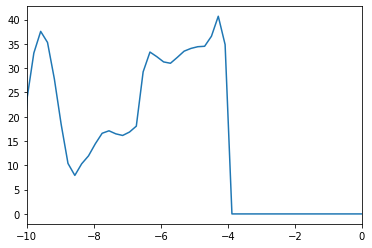

In [33]:
plt.plot(
    calcnode.outputs.arrays.get_array("energies"),
    calcnode.outputs.arrays.get_array("total"))
plt.gca().set_xbound(-10, 0)

(doss_projections)=

## Computing Projections

Projections can be added per atom or per orbital set.

:::{note}
A maximum of 15 projections are allowed per calculation.
:::{note}

In [6]:
orm.Dict(dict={
    "shrink_is": 18,
    "shrink_isp": 36,
    "npoints": 100,
    "band_minimum": -10,
    "band_maximum": 10,
    "band_units": "eV",
    "atomic_projections": [0, 1],
    "orbital_projections": [[1, 2, 3]]
})

<Dict: uuid: c2ec5f24-bd4b-46fe-ba21-23b121ad3f6d (unstored)>

In order to create orbital sets,
it is possible to compute the nature of each orbital,
using the atomic structure and basis sets used to create the ``fort.9``:

In [3]:
from aiida_crystal17.tests import get_test_structure_and_symm
from aiida_crystal17.symmetry import print_structure
structure, _ = get_test_structure_and_symm('NiO_afm')
print_structure(structure)

StructureData Summary
Lattice
    abc : 2.944 2.944 4.164
 angles :  90.0  90.0  90.0
 volume :  36.1
    pbc : True True True
      A : 2.944   0.0   0.0
      B :   0.0 2.944   0.0
      C :   0.0   0.0 4.164
Kind  Symbols Position
----  ------- --------
Ni1   Ni      0.0     0.0     0.0    
Ni2   Ni      1.472   1.472   2.082  
O     O       0.0     0.0     2.082  
O     O       1.472   1.472   0.0    


In [4]:
basis_cls = plugins.DataFactory('crystal17.basisset')
basis_sets = basis_cls.get_basissets_from_structure(structure, 'sto3g')
basis_data = {k: v.get_data() for k, v in basis_sets.items()}
basis_data

{'Ni': {'type': 'all-electron',
  'bs': [{'type': 'S', 'functions': ['STO-nG(nd) type 3-21G core shell']},
   {'type': 'SP', 'functions': ['STO-nG(nd) type 3-21G core shell']},
   {'type': 'SP', 'functions': ['STO-nG(nd) type 3-21G core shell']},
   {'type': 'SP', 'functions': ['STO-nG(nd) type 3-21G core shell']},
   {'type': 'D', 'functions': ['STO-nG(nd) type 3-21G core shell']}]},
 'O': {'type': 'all-electron',
  'bs': [{'type': 'S', 'functions': ['STO-nG(nd) type 3-21G core shell']},
   {'type': 'SP', 'functions': ['STO-nG(nd) type 3-21G core shell']}]}}

In [5]:
from aiida_crystal17.parsers.raw.parse_bases import compute_orbitals
cresult = compute_orbitals(structure.get_ase().numbers, basis_data)
print("number of electrons: ", cresult.electrons)
print("number of core electrons: ", cresult.core_electrons)
cresult.ao_indices

number of electrons:  72
number of core electrons:  40


{1: {'atom': 0, 'element': 'Ni', 'type': 'S', 'index': 1},
 2: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 1},
 3: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 1},
 4: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 1},
 5: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 1},
 6: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 2},
 7: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 2},
 8: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 2},
 9: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 2},
 10: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 3},
 11: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 3},
 12: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 3},
 13: {'atom': 0, 'element': 'Ni', 'type': 'SP', 'index': 3},
 14: {'atom': 0, 'element': 'Ni', 'type': 'D', 'index': 1},
 15: {'atom': 0, 'element': 'Ni', 'type': 'D', 'index': 1},
 16: {'atom': 0, 'element': 'Ni', 'type': 'D', 'index': 1},
 17: {'atom': 0, 'element': 'Ni', 'ty

To observe DoS at the fermi level,
these results can also be used to choose a sensible range of bands:

In [6]:
filled_bands = int(cresult.electrons / 2)
first_band = int(cresult.core_electrons / 2) + 1
last_band = min([first_band + 2 * (filled_bands - first_band), cresult.number_ao])
first_band, last_band

(21, 46)

In [7]:
O_sp_orbitals = [k for k, v in cresult.ao_indices.items()
                 if v["element"] == "O" and v["type"] == "SP"]
Ni_d_orbitals = [k for k, v in cresult.ao_indices.items()
                 if v["element"] == "Ni" and v["type"] == "D"]

In [8]:
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.doss', computer, 'mock_properties17')

builder = code.get_builder()
builder.metadata = get_default_metadata()
builder.parameters = orm.Dict(dict={
    "k_points": [18, 36],
    "npoints": 1000,
    "band_minimum": first_band,
    "band_maximum": last_band,
    "band_units": "bands",
    "orbital_projections": [O_sp_orbitals, Ni_d_orbitals]
})
with open_resource_binary('doss', 'nio_sto3g_afm', 'fort.9') as handle:
    builder.wf_folder = orm.SinglefileData(handle)

In [9]:
result2, calcnode2 = engine.run_get_node(builder)

In [11]:
calcnode2.outputs.arrays.attributes

{'array|energies': [1002],
 'array|total_beta': [1002],
 'array|total_alpha': [1002],
 'array|projections_beta': [2, 1002],
 'array|projections_alpha': [2, 1002]}

In [13]:
round(calcnode2.res.fermi_energy, 2)

6.89

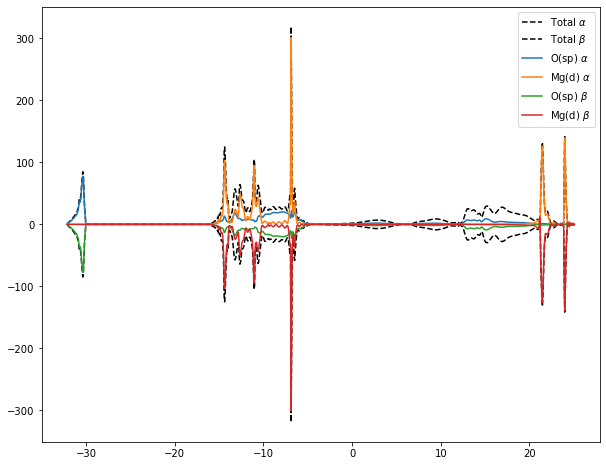

In [26]:
plt.plot(
    calcnode2.outputs.arrays.get_array("energies"),
    calcnode2.outputs.arrays.get_array("total_alpha"),
    label="Total $\\alpha$",
    color="black", linestyle="dashed"
)
plt.plot(
    calcnode2.outputs.arrays.get_array("energies"),
    calcnode2.outputs.arrays.get_array("total_beta"),
    label="Total $\\beta$",
    color="black", linestyle="dashed"
)
plt.plot(
    calcnode2.outputs.arrays.get_array("energies"),
    calcnode2.outputs.arrays.get_array("projections_alpha")[0],
    label="O(sp) $\\alpha$"
)
plt.plot(
    calcnode2.outputs.arrays.get_array("energies"),
    calcnode2.outputs.arrays.get_array("projections_alpha")[1],
    label="Mg(d) $\\alpha$"
)
plt.plot(
    calcnode2.outputs.arrays.get_array("energies"),
    calcnode2.outputs.arrays.get_array("projections_beta")[0],
    label="O(sp) $\\beta$"
)
plt.plot(
    calcnode2.outputs.arrays.get_array("energies"),
    calcnode2.outputs.arrays.get_array("projections_beta")[1],
    label="Mg(d) $\\beta$"
)
plt.legend();
plt.gcf().set_size_inches(10, 8)